<a href="https://colab.research.google.com/github/maryamhashemi/Persian_VQA/blob/master/pvqa_feature_extractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Prerequesties

In [ ]:
BASE_PATH = '/content/drive/My Drive/Persian_VQA/'
QUESTION_TRAIN_PATH =   os.path.join(BASE_PATH, 'OpenEnded_mscoco_train2014_questions.json')
IMAGE_TRAIN_PATH = os.path.join('/content/', 'train2014')
IMAGE_VAL_PATH = os.path.join('/content/', 'val2014')
IMAGE_TEST_PATH = os.path.join('/content/', 'test2015')

In [ ]:
!pip install deepdish

In [ ]:
import os
import re
import logging
import numpy as np
import pandas as pd
from PIL import Image
import deepdish as dd
# from constants import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array


logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

formatter = logging.Formatter('%(asctime)s:%(name)s:%(message)s')

file_handler = logging.FileHandler('prepare_images.log')
file_handler.setFormatter(formatter)

stream_handler = logging.StreamHandler()

logger.addHandler(file_handler)
logger.addHandler(stream_handler)


def read_image_paths(dir_path):
    """
    read the path of images in 'dir_path' and return a dictionary mapping image_id to image path.
    Arguments:
    dir_path -- a directory that consists of images.
    Return:
    ims -- a dictionary that maps image_id to image path.
    """
    ims = {}

    for filename in os.listdir(dir_path):
        if filename.endswith('.jpg'):
            image_id = int(re.findall('\d+', filename)[1])
            ims[image_id] = os.path.join(dir_path, filename)

    return ims


def load_and_proccess_image(image_path, model, image_size):
    """
    load and preprocess image, then extract features using model.
    Arguments:
    image_path -- a string that is image path.
    model -- a cnn model for extracting features from image.
    image_size -- expected size of image after loading.
    Return:
    features -- extracted features from image.
    """
    im = load_img(image_path, target_size=image_size)
    x = img_to_array(im)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    features = model.predict(x)

    return features[0]


def extract_features(paths):
    """
    extract features from images using VGG19.
    Arguments:
    paths -- a dictionary that maps image_ids to image paths.
    Return:
    ims -- a dictionary that saves mapping between image_ids and image features.
    """
    ims = {}
    base_model = VGG19(weights='imagenet', include_top=True)
    model = Model(inputs=base_model.input,
                  outputs=base_model.get_layer('fc2').output)

    num_ims = len(paths)
    for i, (image_id, image_path) in enumerate(paths.items()):
        ims[image_id] = load_and_proccess_image(
            image_path, model, (224, 224, 3))

        if (i+1) % 100 == 0:
            logger.info("extract features from %i/%i images." %
                        (i + 1, num_ims))
    return ims


def get_train_image_paths():
    return read_image_paths(IMAGE_TRAIN_PATH)


def get_val_image_paths():
    return read_image_paths(IMAGE_VAL_PATH)


def get_test_image_paths():
    return read_image_paths(IMAGE_TEST_PATH)


def save_train_features():
    """
    extract features from train images using VGG19 and save them as .csv and .h5 file.
    """
    logger.info("Start: extract features from train images.")
    train_ims = extract_features(get_train_image_paths())
    logger.info("End: extract features from train images.")

    # .csv
    # df = pd.DataFrame(train_ims)
    # df.to_csv('dataset/vgg19/X_train_ims_VGG19.csv')
    # logger.info('saved in \"X_train_ims_VGG19.csv\".')

    # .h5
    dd.io.save('train_full_VGG19.h5',
               train_ims, compression=None)
    logger.info('saved in \"X_train_ims_VGG19.h5\".')


def save_val_features():
    """
    extract features from validation images using VGG19 and save them as .csv and .h5 file.
    """
    logger.info("Start: extract features from val images.")
    val_ims = extract_features(get_val_image_paths())
    logger.info("End: extract features from val images.")

    # .csv
    df = pd.DataFrame(val_ims)
    df.to_csv('X_val_ims_VGG19.csv')
    logger.info('saved in \"X_val_ims_VGG19.csv\".')

    # .h5
    dd.io.save('X_val_ims_VGG19.h5',
               val_ims, compression=None)
    logger.info('saved in \"X_val_ims_VGG19.h5\".')


def save_test_features():
    """
    extract features from test images using VGG19 and save them as .csv and .h5 file.
    """
    logger.info("Start: extract features from test images.")
    test_ims = extract_features(get_test_image_paths())
    logger.info("End: extract features from test images.")

    # .csv
    df = pd.DataFrame(test_ims)
    df.to_csv('X_test_ims_VGG19.csv')
    logger.info('saved in \"X_test_ims_VGG19.csv\."')

    # .h5
    dd.io.save('X_test_ims_VGG19.h5',
               test_ims, compression=None)
    logger.info('saved in \"X_test_ims_VGG19.h5\".')


# save_train_features()
# save_val_features()
# save_test_features()

In [ ]:
save_train_features()

In [ ]:
! pip install arabic_reshaper 
! pip install python-bidi

  Created wheel for arabic-reshaper: filename=arabic_reshaper-2.1.0-cp36-none-any.whl size=16501 sha256=81d29416ba2e5f1258504cda6c51248ce1c9bc2914c3b3ec9be12cb91f844e0b
  Stored in directory: /root/.cache/pip/wheels/a9/e6/ec/2ba48138d4447d40442dd6ba3bf6b92d9c6afd74e9c720c6fe
Successfully built arabic-reshaper


In [ ]:
import os
import re
import json
import numpy as np
from PIL import Image
import arabic_reshaper
from collections import Counter
import matplotlib.pyplot as plt
from bidi.algorithm import get_display
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Multiply, Input

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# !cp -ar /content/X_train_ims_VGG19.h5 /content/drive/My\ Drive/parssoftco_PVQA/X_train_ims_VGG19.h5
!cp -ar /content/X_test_ims_VGG19.csv /content/drive/My\ Drive/parssoftco_PVQA/rez_vgg19_features/X_test_ims_VGG19.csv
!cp -ar /content/X_test_ims_VGG19.h5 /content/drive/My\ Drive/parssoftco_PVQA/rez_vgg19_features/X_test_ims_VGG19.h5

### Set Parameters

In [ ]:
DROPOUT_RATE = 0.5
EMBEDDING_DIM = 300
EPOCHS = 10
BATCH_SIZE = 256
SEQ_LENGTH = 100
VOCAB_SIZE = 1000
OOV_TOK = "<OOV>"

BASE_PATH = '/content/drive/My Drive/Persian_VQA/'
QUESTION_TRAIN_PATH =   os.path.join(BASE_PATH, 'OpenEnded_mscoco_train2014_questions.json')
ANNOTATION_TRAIN_PATH = os.path.join(BASE_PATH, 'mscoco_train2014_annotations.json')
# IMAGE_TRAIN_PATH = os.path.join(BASE_PATH, 'train_images_1000')
IMAGE_TRAIN_PATH = os.path.join('/content/', 'train')

QUESTION_VAL_PATH =   os.path.join(BASE_PATH, 'OpenEnded_mscoco_val2014_questions.json')
ANNOTATION_VAL_PATH = os.path.join(BASE_PATH, 'mscoco_val2014_annotations.json')
# IMAGE_VAL_PATH = os.path.join(BASE_PATH, 'val_images_500')
IMAGE_VAL_PATH = os.path.join('/content/', 'val')

QUESTION_TEST_PATH =   os.path.join(BASE_PATH, '...')
ANNOTATION_TEST_PATH = os.path.join(BASE_PATH, '...')
# IMAGE_TEST_PATH = os.path.join(BASE_PATH, 'val_images_500')
IMAGE_TEST_PATH = os.path.join('/content/', 'test')

In [ ]:
# import os
from zipfile import ZipFile

# #If the downloaded file is a zip file than you can use below function to unzip it.
def unzip(dir,where):
    with ZipFile(dir) as zipf:
        zipf.extractall(where)
    print("File Unzipped!")
# uncompress_features_labels('/content/drive/My Drive/Persian_VQA/mscoco_train2014_english.zip','/content/drive/My Drive/Persian_VQA/')

In [ ]:

!wget https://filebox.ece.vt.edu/~jiasenlu/codeRelease/vqaRelease/train_only/data_train_val.zip

--2020-07-26 16:26:37--  https://filebox.ece.vt.edu/~jiasenlu/codeRelease/vqaRelease/train_only/data_train_val.zip
Resolving filebox.ece.vt.edu (filebox.ece.vt.edu)... 128.173.88.43
Connecting to filebox.ece.vt.edu (filebox.ece.vt.edu)|128.173.88.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 716074236 (683M) [application/zip]
Saving to: ‘data_train_val.zip’

data_train_val.zip  100%[===================>] 682.90M  6.42MB/s    in 1m 48s  

2020-07-26 16:28:27 (6.30 MB/s) - ‘data_train_val.zip’ saved [716074236/716074236]



In [ ]:
unzip('/content/data_train_val.zip','/content/drive/My Drive/Persian_VQA/')
#data_img.h5 data_prepro.h5 data_prepro.json

File Unzipped!


In [ ]:
# !wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/Annotations_Train_mscoco.zip
!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/Annotations_Val_mscoco.zip
# !wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/Questions_Train_mscoco.zip
!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/Questions_Val_mscoco.zip

--2020-08-03 02:10:58--  https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/Annotations_Val_mscoco.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.248.14
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.248.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6031604 (5.8M) [application/zip]
Saving to: ‘Annotations_Val_mscoco.zip’

        Annotations  68%[============>       ]   3.94M  8.71MB/s               ^C
--2020-08-03 02:11:01--  https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/Questions_Val_mscoco.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.88.189
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.88.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10594497 (10M) [application/zip]
Saving to: ‘Questions_Val_mscoco.zip’

Questions_Val_mscoc 100%[===================>]  10.10M  16.2MB/s    in 0.6s    

2020-08-03 02:11:01 (16.2 MB/s) - ‘Questions_Val_mscoco.zip’ saved [10594497/10594497]



KeyboardInterrupt: ignored

In [ ]:
unzip('/content/Annotations_Train_mscoco.zip','/content/drive/My Drive/Persian_VQA/')
unzip('/content/Annotations_Val_mscoco.zip','/content/drive/My Drive/Persian_VQA/')
unzip('/content/Questions_Train_mscoco.zip','/content/drive/My Drive/Persian_VQA/')
unzip('/content/Questions_Val_mscoco.zip','/content/drive/My Drive/Persian_VQA/')



File Unzipped!
File Unzipped!
File Unzipped!
File Unzipped!


In [ ]:
# !wget http://images.cocodataset.org/zips/train2014.zip
# !wget http://images.cocodataset.org/zips/val2014.zip
!wget http://images.cocodataset.org/zips/test2015.zip


--2020-07-30 14:27:44--  http://images.cocodataset.org/zips/test2015.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.171.59
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.171.59|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13270587935 (12G) [application/zip]
Saving to: ‘test2015.zip’

test2015.zip        100%[===================>]  12.36G  43.9MB/s    in 7m 31s  

2020-07-30 14:35:15 (28.1 MB/s) - ‘test2015.zip’ saved [13270587935/13270587935]



In [ ]:
# unzip('/content/train2014.zip','/content/')
# unzip('/content/val2014.zip','/content/')
unzip('/content/test2015.zip','/content/')

File Unzipped!


In [ ]:
!rm -r /content/val2014

In [ ]:
# !ls /content/drive/My\ Drive/parssoftco_PVQA/train2014 | wc -l
!ls /content/test | wc -l

2500


In [ ]:
import os
import glob

files = glob.glob('/content/test/*')
i=0
for f in files:
    if i==2500:
      break
    os.remove(f)

    i+=1

In [ ]:
!cp -ar /content/train2014 /content/drive/My\ Drive/parssoftco_PVQA/

In [ ]:
!cp -ar /content/test /content/drive/My\ Drive/parssoftco_PVQA/





In [ ]:
!cp -ar /content/train /content/drive/My\ Drive/parssoftco_PVQA/

In [ ]:
!cp -ar /content/val /content/drive/My\ Drive/parssoftco_PVQA/

In [ ]:
import os
import shutil
def move_files(abs_dirname,to_dir,train,val,test):
    
    """Move files into subdirectories."""

    files = [os.path.join(abs_dirname, f) for f in os.listdir(abs_dirname)]

    i = 0
    curr_subdir = None

    for f in files:
        # create new subdir if necessary
        if i == 0:
            subdir_name = os.path.join(to_dir,'test')
            os.mkdir(subdir_name)
            curr_subdir = subdir_name
        if i == (train):
            break
            subdir_name = os.path.join(to_dir,'val')
            os.mkdir(subdir_name)
            curr_subdir = subdir_name
        if i == (train+val):
            subdir_name = os.path.join(to_dir,'test')
            os.mkdir(subdir_name)
            curr_subdir = subdir_name
        if i == (train+val+test):
            break


        # move file to current dir
        f_base = os.path.basename(f)
        shutil.move(f, os.path.join(subdir_name, f_base))
        i += 1

In [ ]:
!rm -r train
!rm -r val
!rm -r test
!rm -r val2014

rm: cannot remove 'train': No such file or directory
rm: cannot remove 'val': No such file or directory
rm: cannot remove 'test': No such file or directory


In [ ]:
!rm -r test

In [ ]:
move_files('/content/train2014/','/content/',5000,2500,5000)

In [ ]:
!rm -r train2014

### Read Data

In [ ]:
def read_image_paths(dir_path):
  ims = {}
  i=0
  for filename in os.listdir(dir_path):
    if filename.endswith('.jpg'):
      image_id = int(re.findall('\d+', filename)[1])
      ims[image_id] = os.path.join(dir_path, filename)
      if(i%500==0):
        print(i)
    i+=1
  return ims

In [ ]:
def load_and_proccess_image(image_path, model):
  im = load_img(image_path, target_size=(224,224,3))
  x = img_to_array(im)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  features = model.predict(x)

  return features[0]

In [ ]:
def read_images(paths):
  ims = {}
  base_model = VGG19(weights='imagenet', include_top=False)

  for layer in base_model.layers:
    layer.trainable=False

  model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)
  i=0
  for image_id, image_path in paths.items():
    ims[image_id] = load_and_proccess_image(image_path, model)
    if(i%500==0):
      print(i)
    i+=1
  return ims

In [ ]:
def get_train_image_paths():
  return read_image_paths(IMAGE_TRAIN_PATH)

In [ ]:
def get_val_image_paths():
  return read_image_paths(IMAGE_VAL_PATH)

In [ ]:
def get_test_image_paths():
  return read_image_paths(IMAGE_TEST_PATH)

In [ ]:
def create_dataset(ims, qus, ann):
  qs = []
  answers = []
  qs_id = []
  im_id = []

  for q in qus['questions']:
    if q['image_id'] in ims.keys():
      qs.append(q['question'])
      qs_id.append(q['question_id'])
      im_id.append(q['image_id'])

  for ann in ann['annotations']:
    if ann['question_id'] in qs_id:
      answer_counts = Counter(a['answer'] for a in ann['answers'])
      answers.append(answer_counts.most_common(1)[0][0])

  return qs, answers, qs_id, im_id

In [ ]:
def get_train_dataset():
  ims = get_train_image_paths()
  qs = json.load( open(QUESTION_TRAIN_PATH))
  ann = json.load( open(ANNOTATION_TRAIN_PATH))
  
  return create_dataset(ims, qs, ann)

In [ ]:
def get_val_dataset():
  ims = get_val_image_paths()
  qs = json.load( open(QUESTION_TRAIN_PATH))
  ann = json.load( open(ANNOTATION_TRAIN_PATH))
  
  return create_dataset(ims, qs, ann)

In [ ]:
def get_test_dataset():
  ims = get_test_image_paths()
  qs = json.load( open(QUESTION_TRAIN_PATH))
  ann = json.load( open(ANNOTATION_TRAIN_PATH))
  
  return create_dataset(ims, qs, ann)

In [ ]:
def get_answers(answers):
  all_answers = np.unique(answers)

  answer_counts = Counter(a for a in train_answers)
  all_answers =[a[0] for a in answer_counts.most_common(1000)]

  return all_answers

#### Visualize Data

In [ ]:
def show_visualqa(qs, answer, image):
  im = Image.open(image)  
  plt.figure()
  plt.imshow(im)
  title = arabic_reshaper.reshape(qs + "\n" + answer)
  title = get_display(title) 
  plt.title(title)
  plt.axis('off')
  plt.show()

def visualize_train(num):
  show_visualqa(train_qs[num], train_answers[num], ims.get(train_image_ids[num]))

In [ ]:
train_qs, train_answers, train_q_ids, train_image_ids = get_train_dataset()
val_qs, val_answers, val_q_ids, val_image_ids = get_val_dataset()
# test_qs, test_answers, test_q_ids, test_image_ids = get_test_dataset()

print('tr ',len(train_qs))
print(len(train_answers))
print(len(train_q_ids))
print(len(train_image_ids))

print(len(val_qs))
print(len(val_answers))
print(len(val_q_ids))
print(len(val_image_ids))

# print(len(test_qs))
# print(len(test_answers))
# print(len(test_q_ids))
# print(len(test_image_ids))

FileNotFoundError: ignored

In [ ]:
li=[]
for t in train_qs:
  li.append(len(t))
question_max_len=np.max(li)

NameError: ignored

In [ ]:
question_max_len

97

0
500
1000
1500
2000
2500
3000
3500
4000
4500


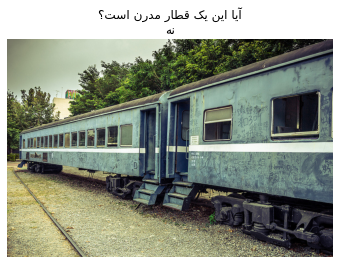

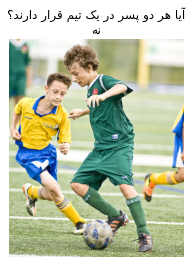

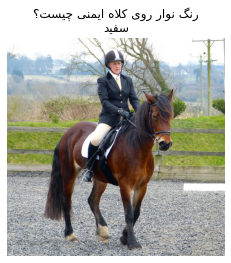

In [ ]:
ims = get_train_image_paths()
visualize_train(0)
visualize_train(2200)
visualize_train(600)

#### Prepare questions to feed into network

In [ ]:
from urllib.request import urlopen
import gzip

# get the vectors
file = gzip.open(urlopen('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ro.300.vec.gz'))
# https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fa.300.bin.gz
# Now let’s prepare this file for vector extraction.

vocab_and_vectors = {}
# put words as dict indexes and vectors as words values
for line in file:
  values = line.split()
  word = values [0].decode('utf-8')
  vector = np.asarray(values[1:], dtype='float32')
  vocab_and_vectors[word] = vector


In [ ]:
#persian fasttext
from urllib.request import urlopen
import gzip

# get the vectors
file_fa = gzip.open(urlopen('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fa.300.vec.gz'))
# https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fa.300.bin.gz
# Now let’s prepare this file for vector extraction.



# import codecs
# f = codecs.open('unicode.rst', encoding='utf-8')
# for line in f:
#     print (repr(line))

vocab_and_vectors_fa = {}
# put words as dict indexes and vectors as words values
for line in file_fa:
  values = line.split()
  # print(values)
  word = values [0].decode('utf-8')
  vector = np.asarray(values[1:], dtype='float32')
  vocab_and_vectors_fa[word] = vector


In [ ]:
vocab_and_vectors_fa['سلام']

In [ ]:
# num_words = VOCAB_SIZE,
tokenizer = Tokenizer( oov_token=OOV_TOK,filters='؟')
word_index = tokenizer.word_index
tokenizer.fit_on_texts(train_qs)

train_X_seqs = tokenizer.texts_to_sequences(train_qs)
val_X_seqs = tokenizer.texts_to_sequences(val_qs)
test_X_seqs = tokenizer.texts_to_sequences(test_qs)

train_X_seqs = pad_sequences(train_X_seqs, maxlen=SEQ_LENGTH, padding='post')
val_X_seqs = pad_sequences(val_X_seqs, maxlen=SEQ_LENGTH, padding='post')
test_X_seqs = pad_sequences(test_X_seqs, maxlen=SEQ_LENGTH, padding='post')

train_X_seqs = np.array(train_X_seqs)
val_X_seqs = np.array(val_X_seqs)
test_X_seqs = np.array(test_X_seqs)


word_index = tokenizer.word_index

NameError: ignored

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
  embedding_vector = vocab_and_vectors_fa.get(word)
  # words that cannot be found will be set to 0
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
word_index

#### Prepare images to feed into network

In [ ]:
train_ims = read_images(get_train_image_paths())
val_ims = read_images(get_val_image_paths())
test_ims = read_images(get_test_image_paths())

train_X_ims = [train_ims[id] for id in train_image_ids]
val_X_ims = [val_ims[id] for id in val_image_ids]
test_X_ims = [test_ims[id] for id in test_image_ids]

train_X_ims = np.array(train_X_ims)
val_X_ims = np.array(val_X_ims)
test_X_ims = np.array(test_X_ims)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
574717952/574710816 [==============================] - 6s 0us/step
0
500
1000
1500
2000
2500
3000
3500
4000
4500
0
500
1000
1500
2000
0
500
1000
1500
2000
0
500
1000
1500
2000
2500
3000
3500
4000
4500
0
500
1000


UnidentifiedImageError: ignored

In [ ]:
import os, h5py

img_data = h5py.File('/content/drive/My Drive/Persian_VQA/data_img.h5')
ques_data = h5py.File('/content/drive/My Drive/Persian_VQA/data_prepro.h5')

img_data = np.array(img_data['images_train'])

img_pos_train = ques_data['img_pos_train'][:]#:data_limit
train_img_data = np.array([img_data[_-1, :] for _ in img_pos_train])
# Normalizing images
tem = np.sqrt(np.sum(np.multiply(train_img_data, train_img_data), axis=1))
train_img_data = np.divide(train_img_data, np.transpose(np.tile(tem, (4096,1))))


train_y = to_categorical(ques_data['answers'])[:, :]#[:data_limit, :]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  after removing the cwd from sys.path.


In [ ]:
img_data = h5py.File('/content/drive/My Drive/Persian_VQA/data_img.h5')
ques_data = h5py.File('/content/drive/My Drive/Persian_VQA/data_prepro.h5')
img_datas = np.array(img_data['images_train'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


In [ ]:
img_datas.shape

(82459, 4096)

In [ ]:
train_img_data.shape

(215359, 4096)

In [ ]:
img_pos_train[0]

24716

In [ ]:

train_data={}
with h5py.File('/content/data_prepro.h5','r') as hf:
    # # total number of training data is 215375
    # # question is (26, )
    # tem = hf.get('ques_train')
    # train_data['question'] = np.array(tem)-1
    # # max length is 23
    # tem = hf.get('ques_length_train')
    # train_data['length_q'] = np.array(tem)
    # total 82460 img
    tem = hf.get('img_pos_train')
    # convert into 0~82459
    train_data['img_list'] = np.array(tem)-1
    # # answer is 1~1000
    # tem = hf.get('answers')
    # train_data['answers'] = np.array(tem)-1


current_img_list = train_data['img_list']
current_imgs = img_feature[current_img_list,:]

print(current_imgs.shape)

# train_img = current_imgs[train_idx,...]

(215359, 4096)


NameError: ignored

In [ ]:
current_img_list

array([24715, 14619, 31893, ..., 41122, 10643, 49936], dtype=uint32)

In [ ]:
img_feature.shape

(82459, 4096)

In [ ]:
img_feature[82458]

array([0.        , 0.        , 0.00270268, ..., 0.        , 0.        ,
       0.02639463], dtype=float32)

In [ ]:
train_ims = read_images(get_train_image_paths())
# val_ims = read_images(get_val_image_paths())
# test_ims = read_images(get_test_image_paths())

train_X_ims = [train_ims[id] for id in train_image_ids]
# val_X_ims = [val_ims[id] for id in val_image_ids]
# test_X_ims = [test_ims[id] for id in test_image_ids]

train_X_ims = np.array(train_X_ims)
# val_X_ims = np.array(val_X_ims)
# test_X_ims = np.array(test_X_ims)

0
500
1000
1500
2000
0
500
1000
1500
2000


In [ ]:
BASE_PATH_parssoft = '/content/drive/My Drive/parssoftco_PVQA/'
# np.save(BASE_PATH_parssoft + 'train_X_ims_5000.npy',train_X_ims)
# np.save(BASE_PATH_parssoft + 'val_X_ims_2500.npy',val_X_ims)
np.save(BASE_PATH_parssoft + 'test_X_ims_2500.npy',test_X_ims)

In [ ]:
BASE_PATH_parssoft = '/content/drive/My Drive/parssoftco_PVQA/'
train_X_ims = np.load(BASE_PATH_parssoft + 'train_X_ims_5000.npy')
val_X_ims = np.load(BASE_PATH_parssoft + 'val_X_ims_2500.npy')
test_X_ims = np.load(BASE_PATH_parssoft + 'test_X_ims_2500.npy')

#### Prepare labels of data.

In [ ]:
all_answers = get_answers(train_answers)
num_answers = len(all_answers)
num_classes = num_answers +1 

train_answer_indices = []
val_answer_indices = []
test_answer_indices = []

for a in train_answers:
  if a in all_answers:
    train_answer_indices.append(all_answers.index(a))
  else:
    train_answer_indices.append(num_answers)
 

for a in val_answers:
  if a in all_answers:
    val_answer_indices.append(all_answers.index(a))
  else: 
    val_answer_indices.append(num_answers)

for a in test_answers:
  if a in all_answers:
    test_answer_indices.append(all_answers.index(a))
  else:
    test_answer_indices.append(num_answers)

train_Y = to_categorical(train_answer_indices)
val_Y = to_categorical(val_answer_indices)
test_Y = to_categorical(test_answer_indices)

print(train_Y.shape)
print(val_Y.shape)

(15000, 301)
(7500, 301)


### Build Vanilla Network

In [ ]:
def img_model(img_input):
  x = Dense(1024, activation='tanh', input_dim = 4096)(img_input)

  return x

In [ ]:
def qs_model(qs_input, num_words, embedding_dim, dropout_rate):
# (Embedding(len(word_index)+1,300,input_length=X.shape[1],weights=[embedding_matrix],trainable=False))
  x = Embedding(len(word_index)+1, embedding_dim, input_length=SEQ_LENGTH, weights=[embedding_matrix],trainable = False)(qs_input)
  # x = Embedding(len(word_index)+1, embedding_dim, input_length=SEQ_LENGTH, trainable = True)(qs_input)
  x = LSTM(units=512, return_sequences=True, input_shape= (None,embedding_dim))(x)
  x = Dropout(dropout_rate)(x)
  x = LSTM(units=512, return_sequences=False)(x)
  x = Dropout(dropout_rate)(x)
  x = Dense(1024, activation='tanh')(x)

  return x

In [ ]:
def vanilla(num_classes, dropout_rate, num_words, embedding_dim):
  qs_input = Input(shape=( SEQ_LENGTH ,))#train_X_seqs.shape[1]
  img_input = Input(shape=(4096,))

  CNN_model = img_model(img_input)
  LSTM_model = qs_model(qs_input, num_words, embedding_dim, dropout_rate)

  x = Multiply()([CNN_model, LSTM_model])
  x = Dropout(0.5)(x)
  x = Dense(1000, activation='tanh')(x)
  x = Dropout(0.5)(x)
  output = Dense(num_classes, activation='softmax')(x)
  
  model = Model(inputs= [qs_input, img_input], outputs= output)
  return model

### Train

In [ ]:
  EPOCHS = 10

In [ ]:
def Train():
  checkpoint = ModelCheckpoint('model.h5', save_best_only=True)

  model = vanilla(num_classes, DROPOUT_RATE, len(word_index)+1, EMBEDDING_DIM)
  model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
  model.summary()
  history = model.fit([train_X_seqs,train_X_ims] ,
                      train_Y, 
                      epochs = 10, 
                      batch_size = BATCH_SIZE, 
                      callbacks = [checkpoint],
                      validation_data=([val_X_seqs,val_X_ims], val_Y) )
  return history, model

In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [ ]:
history, model = Train()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 100, 300)     1156800     input_29[0][0]                   
__________________________________________________________________________________________________
lstm_22 (LSTM)                  (None, 100, 512)     1665024     embedding_11[0][0]               
__________________________________________________________________________________________________
dropout_44 (Dropout)            (None, 100, 512)     0           lstm_22[0][0]                    
___________________________________________________________________________________________

In [ ]:
def plot_accuracy_loss(history):
  acc      = history.history[     'accuracy' ]
  val_acc  = history.history[ 'val_accuracy' ]
  loss     = history.history[    'loss' ]
  val_loss = history.history['val_loss' ]

  epochs   = range(len(acc))

  plt.plot  ( epochs,     acc, label='train_acc' )
  plt.plot  ( epochs, val_acc, label='val_acc' )
  plt.title ('Training and validation accuracy')
  plt.legend()
  plt.savefig(BASE_PATH + 'Training and validation accuracy.jpg')
  plt.figure()

  plt.plot  ( epochs,     loss, label='train_loss' )
  plt.plot  ( epochs, val_loss, label='val_loss' )
  plt.title ('Training and validation loss'   )
  plt.legend()
  plt.savefig(BASE_PATH + 'Training and validation loss.jpg')

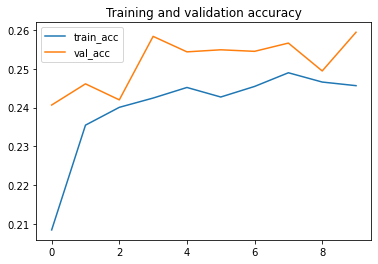

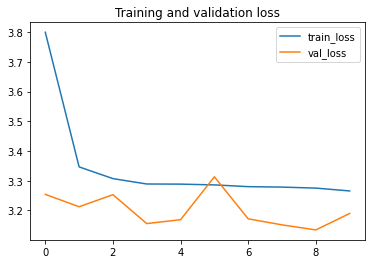

In [ ]:
plot_accuracy_loss(history)

### Evaluate

In [ ]:
def Evaluation(model):
  results = model.evaluate([test_X_seqs,test_X_ims], test_Y, batch_size=64)
  print('test loss, test acc:', results)
Evaluation(model)

118/118 [==============================] - 6s 49ms/step - loss: 3.2102 - accuracy: 0.2527
test loss, test acc: [3.2102348804473877, 0.2526666522026062]
